# Тематическое моделирование LDA, LSI 
## Gensim

In [4]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 5.8 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim # NLP библиотека (TFIDF, W2T, D2T, FastText, LSA, LDA и т.д.)
import pymorphy2 # лемматизатор
import re # регулярные выражения
import os # работа с операционной системой (сздание фалов, директорий, запись)
import pickle # сохранениt и загрузка сложных объектов в Python (поток байтов)
from collections import defaultdict # как обычный словарь, только вызывает значения
from functools import lru_cache # для кеширование результата выполнения функции
from tqdm import tqdm # индикатор выполнения 
from nltk import word_tokenize # токенизатор 
from nltk.corpus import stopwords # стоп-слова
from gensim.corpora import Dictionary # создания словаря частотности токенов в тексте

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# какие модели есть в библиотке gensim
dir(gensim.models)

['AtireBM25Model',
 'AuthorTopicModel',
 'BackMappingTranslationMatrix',
 'CoherenceModel',
 'Doc2Vec',
 'EnsembleLda',
 'FAST_VERSION',
 'FastText',
 'HdpModel',
 'KeyedVectors',
 'LdaModel',
 'LdaMulticore',
 'LdaSeqModel',
 'LogEntropyModel',
 'LsiModel',
 'LuceneBM25Model',
 'Nmf',
 'NormModel',
 'OkapiBM25Model',
 'Phrases',
 'RpModel',
 'TfidfModel',
 'TranslationMatrix',
 'VocabTransform',
 'Word2Vec',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_fasttext_bin',
 'atmodel',
 'basemodel',
 'bm25model',
 'callbacks',
 'coherencemodel',
 'doc2vec',
 'doc2vec_corpusfile',
 'doc2vec_inner',
 'ensemblelda',
 'fasttext',
 'fasttext_corpusfile',
 'fasttext_inner',
 'hdpmodel',
 'interfaces',
 'keyedvectors',
 'ldamodel',
 'ldamulticore',
 'ldaseqmodel',
 'logentropy_model',
 'lsimodel',
 'nmf',
 'nmf_pgd',
 'normmodel',
 'phrases',
 'rpmodel',
 'tfidfmodel',
 'translation_matrix',
 'utils',
 'word2vec',


In [3]:
morph = pymorphy2.MorphAnalyzer()

In [4]:
# новости из корпуса Тайга

In [5]:
# запишем путь к корпусу в переменную
dataset_folder = '/Users/user/Taiga_news/Interfax_example'

In [6]:
# функция .listdir() возвращает список, содержащий имена файлов и директорий в каталоге
files = os.listdir(dataset_folder)

In [7]:
# посмотри сколько файлов в каталоге (длинна списка) 
len(files)

749

In [8]:
#  на 5 последних файла (обращение к элементам списка)
files[:5]

['business206746.txt',
 'business202252.txt',
 'russia202828.txt',
 'russia224623.txt',
 'russia230118.txt']

In [9]:
# функцией open(..., 'r') для открытия файлов txt откроем 300-й файл в каталоге os

with open(os.path.join(dataset_folder, files[300]), 'r') as f:
    print(f.read())


Российские фигуристы Татьяна Волосожар и Максим Траньков впервые в карьере стали чемпионами мира. Их произвольную программу судьи оценили в 149,87 балла, а в сумме Волосожар и Траньков получили 225,71 балла. Ближайших преследователей Татьяна и Максим опередили более чем на 20 баллов. Это первое за 8 лет российское "золото" в парном катании. 
Второе место заняли четырехкратные чемпионы мира немцы Алена Савченко и Робин Шолковы, несмотря на неидеальный прокат они смогли набрать 205,56 балла и опередить хозяев льда Меган Дюамель и Эрика Редфорда – канадцы уступили прошлогодним победителям ровно 1 балл.
Канадский Лондон так яростно поддерживал своих спортсменов, что местных болельщиков смогли приятно удивить обе пары. Кирстен Мур-Тауэрс и Дилан Москович были на 5-м месте после короткой программы, а после произвольной и вовсе поднялись на 4-ю строчку. Их выступление не было безупречным, но достаточным для того, чтобы произвести благоприятное впечатление не судей и привести в восторг трибун

### Запишем датасет в память

In [10]:
# объединить два или более компонентов пути через os.path.join(...)
# например:
print (os.path.join('a', 'b', 'c'))
# только далее вместо 'a', 'b', 'c' пойдут имена файлов txt в каталоге 
print()
print(os.path.join('/Users/user/Taiga_news/Interfax_example/business201052.txt', 
                   '/Users/user/Taiga_news/Interfax_example/culture199142.txt', 
                   '/Users/user/Taiga_news/Interfax_example/sport207111.txt'))

a/b/c

/Users/user/Taiga_news/Interfax_example/sport207111.txt


In [11]:
# пустой список texts, в который будем циклом добавлять тексты как элементы списка, читая их в каталоге os
texts = []

for file in files:
    with open(os.path.join(dataset_folder, file), 'r') as f:
        texts.append(f.read())

In [12]:
# посмотрим как отработал
print('количество текстов в списке:', len(texts))
print()
print(texts[299])

количество текстов в списке: 749


Если вы турист и плохо говорите по-английски, не собираетесь ходить по супермаркетам, больше любите сок и кока-колу, а не обычную воду, не знаете, для чего нужны все эти мешки, то, приехав в Бангкок, вы ничего не заметите: никто не паникует, алкоголь на каждом углу, кафе не закрылись, лотки с едой и фруктами не разъехались, королевский дворец стоит, тайские девушки по-прежнему прекрасны, а зазывалы изобретательны. А если вы прилетите в любой другой международный аэропорт Таиланда, то не увидите даже мешков.

***

Наводнение не напало на нас в один момент: еще месяц назад мы видели по телевизору, что в северных провинциях все плохо, три недели назад во время поездки в Камбоджу видели подтопленные дома, а кое-где была залита и дорога. Автобус сбрасывал скорость, проезжал лужу и наводнение нас больше не касалось. Тогда же я видела, что в северо-восточном пригороде Бангкока многие дома затоплены сантиметров на сорок-пятьдесят.
В тот же день обсуждали, сто

### Очистим тексты от лишних смиволов

In [13]:
# напишем функцию которая очистит тексты от лишних символов преведет к нижнему регистру и уберет цифры
# используем метод .replace() и регулярные выражения
def clear_text(t):
    #t = str(t).lower()
    t = t.replace('\n', ' ')
    #t = t.replace('.', '. ')
    #t = t.replace(',', ', ')
    t = t.replace('***', ' ')
    t = re.sub(r'[^a-zA-Zа-яА-ЯёЁ]', ' ', t).split()
    cl_text = " ".join(t)
        
    return cl_text 

In [14]:
# применим функцию clear_text в цикле к каждому тексту, результат будет записан в список []
cl_texts = [clear_text(t) for t in texts]

In [15]:
cl_texts[299]

'Если вы турист и плохо говорите по английски не собираетесь ходить по супермаркетам больше любите сок и кока колу а не обычную воду не знаете для чего нужны все эти мешки то приехав в Бангкок вы ничего не заметите никто не паникует алкоголь на каждом углу кафе не закрылись лотки с едой и фруктами не разъехались королевский дворец стоит тайские девушки по прежнему прекрасны а зазывалы изобретательны А если вы прилетите в любой другой международный аэропорт Таиланда то не увидите даже мешков Наводнение не напало на нас в один момент еще месяц назад мы видели по телевизору что в северных провинциях все плохо три недели назад во время поездки в Камбоджу видели подтопленные дома а кое где была залита и дорога Автобус сбрасывал скорость проезжал лужу и наводнение нас больше не касалось Тогда же я видела что в северо восточном пригороде Бангкока многие дома затоплены сантиметров на сорок пятьдесят В тот же день обсуждали стоит ли нам опасаться и чего Очевидно было что живя на пятом этаже дом

In [16]:
# посмотрим на количество слов в очищенных текстах 
# для этого разобьем тексты на токены (в данном случае слова разделенные пробелами) и узнаем длинну len(t.split())
# проделаем это это для всех текстов в цикеле for t in cl_texts и запишем в список []
# 
words_in_texts = [len(t.split()) for t in cl_texts]

In [17]:
# посмотрим на этот список
print(words_in_texts)

[837, 820, 684, 1214, 908, 939, 2791, 756, 722, 767, 1564, 943, 816, 887, 680, 834, 1235, 1129, 1621, 770, 978, 710, 751, 2061, 1781, 788, 943, 779, 854, 908, 1052, 711, 703, 982, 2649, 1083, 798, 824, 794, 721, 1076, 706, 939, 992, 1010, 744, 1597, 756, 1181, 833, 1225, 933, 1874, 1635, 705, 712, 687, 1048, 974, 787, 753, 739, 1230, 783, 2567, 949, 1017, 809, 745, 1197, 1331, 981, 1213, 748, 822, 694, 921, 758, 1205, 774, 2098, 733, 782, 905, 1346, 1164, 709, 849, 716, 1110, 951, 938, 1018, 1764, 1100, 893, 892, 742, 1787, 1560, 697, 697, 761, 1103, 834, 788, 975, 686, 1155, 982, 742, 2188, 1213, 1057, 1171, 1155, 696, 784, 1051, 1134, 1106, 828, 3220, 1019, 934, 894, 807, 868, 1926, 1848, 1309, 734, 859, 1068, 763, 1184, 913, 1067, 1001, 2670, 689, 1046, 1099, 947, 1378, 736, 1113, 1052, 1170, 1201, 1044, 666, 2786, 858, 1159, 834, 871, 745, 891, 1416, 2137, 692, 2242, 1039, 1151, 1267, 943, 838, 1098, 1509, 1382, 764, 874, 690, 793, 930, 1859, 997, 892, 1160, 704, 1103, 712, 964, 67

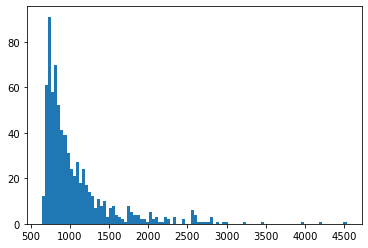

In [18]:
# посмотрим на распределение текстов по длинне слов
plt.hist(words_in_texts, bins=100)
plt.show()

Тексты начинаются от длинны 500+ слов. <br><br>
Есть выбросы - отдельные тексты длинее 3000 слов.

In [19]:
# уберем тексты с длинной слов больше 3000
# нужна ли нижняя граница по количеству слов тексте? В данном случае нет.

cl_texts_3000 = []

for t in cl_texts:
    if len(t.split()) <= 3000:
        cl_texts_3000.append(t)

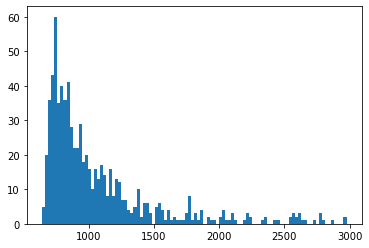

In [20]:
# снова посмотрим на распределение текстов по длинне слов

words_in_texts = [len(t.split()) for t in cl_texts_3000]
plt.hist(words_in_texts, bins=100)
plt.show()

## Токенизируем тексты 
### в данном случае на слова разделенные пробелом

In [27]:
texts_tokenized = [t.split() for t in tqdm(cl_texts)]

100%|██████████| 749/749 [00:00<00:00, 5422.39it/s]


In [28]:
# альтернативные способ через nltk word_tokenize отрабатывает дольше
# иногда подходит только nltk или иной токенизатор
# t_t = [word_tokenize(t) for t in tqdm(cl_texts)]

In [29]:
# посмотрим как отработал токенизатор 
texts_tokenized[299]

['Если',
 'вы',
 'турист',
 'и',
 'плохо',
 'говорите',
 'по',
 'английски',
 'не',
 'собираетесь',
 'ходить',
 'по',
 'супермаркетам',
 'больше',
 'любите',
 'сок',
 'и',
 'кока',
 'колу',
 'а',
 'не',
 'обычную',
 'воду',
 'не',
 'знаете',
 'для',
 'чего',
 'нужны',
 'все',
 'эти',
 'мешки',
 'то',
 'приехав',
 'в',
 'Бангкок',
 'вы',
 'ничего',
 'не',
 'заметите',
 'никто',
 'не',
 'паникует',
 'алкоголь',
 'на',
 'каждом',
 'углу',
 'кафе',
 'не',
 'закрылись',
 'лотки',
 'с',
 'едой',
 'и',
 'фруктами',
 'не',
 'разъехались',
 'королевский',
 'дворец',
 'стоит',
 'тайские',
 'девушки',
 'по',
 'прежнему',
 'прекрасны',
 'а',
 'зазывалы',
 'изобретательны',
 'А',
 'если',
 'вы',
 'прилетите',
 'в',
 'любой',
 'другой',
 'международный',
 'аэропорт',
 'Таиланда',
 'то',
 'не',
 'увидите',
 'даже',
 'мешков',
 'Наводнение',
 'не',
 'напало',
 'на',
 'нас',
 'в',
 'один',
 'момент',
 'еще',
 'месяц',
 'назад',
 'мы',
 'видели',
 'по',
 'телевизору',
 'что',
 'в',
 'северных',
 'провин

## Удалим стоп-слова и слова, длинна которых меньше 3-х букв

In [30]:
# установили спиок стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

In [31]:
# работаем со списокм внутри списка: список слов внутри списка текстов и возвращаем такую же структуру
# слово за словм в тексте слово не должно быть в списке стоп-слов и его длинна должна быть больше 3-х
# текст за текстом в токенизированных текстах
tk_text = [[w for w in t if (w not in stop_words and len(w) > 3)]
           for t in tqdm(texts_tokenized)] 

100%|██████████| 749/749 [00:00<00:00, 1845.10it/s]


In [32]:
# посмотрим на результат
tk_text[299]

['Если',
 'турист',
 'плохо',
 'говорите',
 'английски',
 'собираетесь',
 'ходить',
 'супермаркетам',
 'любите',
 'кока',
 'колу',
 'обычную',
 'воду',
 'знаете',
 'нужны',
 'мешки',
 'приехав',
 'Бангкок',
 'заметите',
 'никто',
 'паникует',
 'алкоголь',
 'каждом',
 'углу',
 'кафе',
 'закрылись',
 'лотки',
 'едой',
 'фруктами',
 'разъехались',
 'королевский',
 'дворец',
 'стоит',
 'тайские',
 'девушки',
 'прежнему',
 'прекрасны',
 'зазывалы',
 'изобретательны',
 'прилетите',
 'любой',
 'международный',
 'аэропорт',
 'Таиланда',
 'увидите',
 'мешков',
 'Наводнение',
 'напало',
 'момент',
 'месяц',
 'назад',
 'видели',
 'телевизору',
 'северных',
 'провинциях',
 'плохо',
 'недели',
 'назад',
 'время',
 'поездки',
 'Камбоджу',
 'видели',
 'подтопленные',
 'дома',
 'залита',
 'дорога',
 'Автобус',
 'сбрасывал',
 'скорость',
 'проезжал',
 'лужу',
 'наводнение',
 'касалось',
 'Тогда',
 'видела',
 'северо',
 'восточном',
 'пригороде',
 'Бангкока',
 'многие',
 'дома',
 'затоплены',
 'сантимет

## Лемматизируем тексты 

In [35]:
from pymystem3 import Mystem
# создадим лемматизатор m объект структуры Mystem  
m = Mystem()

In [36]:
# работаем со списокм внутри списка: список слов внутри списка текстов и возвращаем такую же структуру
# лемматизируем слово за словом в виде строки в тексте (берем 1-й элемент [0], т.е. саму лемму, доп. инф. не нужна)
# текст за текстом (если тексты длинные их предварительно надо разбить на куски/чанки, так отработает быстрее)

lm_text = [[(m.lemmatize(str(w))[0]) for w in t] 
           for t in tqdm(tk_text)] 

100%|██████████| 749/749 [01:03<00:00, 11.74it/s]


In [37]:
# посмотрим как отработал лемматизатор 
lm_text[299]

['если',
 'турист',
 'плохо',
 'говорить',
 'английски',
 'собираться',
 'ходить',
 'супермаркет',
 'любить',
 'кока',
 'кол',
 'обычный',
 'вода',
 'знать',
 'нужный',
 'мешок',
 'приезжать',
 'бангкок',
 'замечать',
 'никто',
 'паниковать',
 'алкоголь',
 'каждый',
 'угол',
 'кафе',
 'закрываться',
 'лоток',
 'еда',
 'фрукт',
 'разъехаться',
 'королевский',
 'дворец',
 'стоять',
 'тайский',
 'девушка',
 'прежний',
 'прекрасный',
 'зазывала',
 'изобретательный',
 'прилетать',
 'любой',
 'международный',
 'аэропорт',
 'таиланд',
 'увидеть',
 'мешок',
 'наводнение',
 'нападать',
 'момент',
 'месяц',
 'назад',
 'видеть',
 'телевизор',
 'северный',
 'провинция',
 'плохо',
 'неделя',
 'назад',
 'время',
 'поездка',
 'камбоджа',
 'видеть',
 'подтоплять',
 'дома',
 'заливать',
 'дорога',
 'автобус',
 'сбрасывать',
 'скорость',
 'проезжать',
 'лужа',
 'наводнение',
 'касаться',
 'тогда',
 'видеть',
 'северо',
 'восточный',
 'пригород',
 'бангкок',
 'многие',
 'дома',
 'затоплять',
 'сантиметр'

## Выделение устойчивых словосочетаний, биграмм

In [41]:
# создадим копию
lm_text_copy = lm_text

In [42]:
# импортировали функцию Phrases()из Gensim
from gensim.models import Phrases

# аргументы Phrases(sentences, min_count=5, threshold=10.0, delimiter=b'_')
# (1) sentences - список of токанизированных предложений (список списков - список предложений и в каждом список слов)
# (2) min_count - мин. частота с которой словосочетание должно встретиться в корпусе, чтобы считаться устойчивым
# (3) threshold -  порого встречаемости, чем выше тем меньше словосочетаний  
# (4) delimiter - разделитель для объединения слов в сочетнии (! замена на delimiter=b' ' не работает) 




In [43]:
# создали объект Phrases() с заданными аргументами 
phrases = Phrases(lm_text_copy, min_count=10, threshold=10)

In [44]:
from tqdm import notebook

In [46]:
# перебираем все тексты по индексу
# перебирем все токены в устойчивых словосочетаниях, которые в каждом тексте нашел Phrases()
# если в этом токене есть разделитель, установленный параметром delimiter=b'_' т.е. это устойчивое словосочетание
# то в заменим '_' на ' ' методом .replace()
# добавим в исходный текст устойчивое словосочетание 

for i in notebook.tqdm(range(len(lm_text_copy))):
    for token in phrases[lm_text_copy[i]]:
        if '_' in token:
            token = token.replace("_", " ")
            lm_text_copy[i].append(token)

In [47]:
# импортируем функцию Dictionary для создания словаря частотности токенов в тексте
from gensim.corpora import Dictionary

In [48]:
# help(Dictionary)

In [49]:
# составили словарь, потом он будет передаваться в модели
dictionary = Dictionary(lm_text_copy)

In [50]:
# отбросили вернрхний и нижний экстретумы
dictionary.filter_extremes(no_below=10, no_above=0.3)

In [128]:
token2id = dictionary.token2id

In [129]:
token2id

{'австрия': 0,
 'адекватный': 1,
 'административный': 2,
 'административный ресурс': 3,
 'актив': 4,
 'активно': 5,
 'активность': 6,
 'акционер': 7,
 'акция': 8,
 'амбициозный': 9,
 'баланс': 10,
 'банка': 11,
 'банка россия': 12,
 'безуспешно': 13,
 'бизнес': 14,
 'бизнесмен': 15,
 'близкий время': 16,
 'брат': 17,
 'бренд': 18,
 'бывший': 19,
 'василий': 20,
 'ведомость': 21,
 'вести': 22,
 'взрыв': 23,
 'видимо': 24,
 'виктор': 25,
 'вкладывать': 26,
 'владелец': 27,
 'вместе': 28,
 'внезапно': 29,
 'вскоре': 30,
 'выполняться': 31,
 'выражать': 32,
 'выражать уверенность': 33,
 'выручка': 34,
 'выставлять': 35,
 'выступать': 36,
 'выясняться': 37,
 'газета': 38,
 'гарантировать': 39,
 'гигантский': 40,
 'говориться': 41,
 'говориться сообщение': 42,
 'гораздо': 43,
 'гостиница': 44,
 'давно': 45,
 'далеко': 46,
 'дальнейший': 47,
 'деятельность': 48,
 'доля': 49,
 'дополнительный': 50,
 'доход': 51,
 'дочерний': 52,
 'елена': 53,
 'жилой': 54,
 'завершать': 55,
 'заказчик': 56,
 '

In [51]:
# посмотрим что лежит в объекте dictionary, это словарь словарей:

# 'token2id':{'австрия': 0, 'адекватный': 1, ...},
# 'id2token': {},
# 'cfs': {167: 225, 192: 830, ...},
# 'dfs': {167: 81,  192: 143, ...},
# 'num_docs': 749,
# 'num_pos': 582863, ...  и т.д.

vars(dictionary)

{'token2id': {'австрия': 0,
  'адекватный': 1,
  'административный': 2,
  'административный ресурс': 3,
  'актив': 4,
  'активно': 5,
  'активность': 6,
  'акционер': 7,
  'акция': 8,
  'амбициозный': 9,
  'баланс': 10,
  'банка': 11,
  'банка россия': 12,
  'безуспешно': 13,
  'бизнес': 14,
  'бизнесмен': 15,
  'близкий время': 16,
  'брат': 17,
  'бренд': 18,
  'бывший': 19,
  'василий': 20,
  'ведомость': 21,
  'вести': 22,
  'взрыв': 23,
  'видимо': 24,
  'виктор': 25,
  'вкладывать': 26,
  'владелец': 27,
  'вместе': 28,
  'внезапно': 29,
  'вскоре': 30,
  'выполняться': 31,
  'выражать': 32,
  'выражать уверенность': 33,
  'выручка': 34,
  'выставлять': 35,
  'выступать': 36,
  'выясняться': 37,
  'газета': 38,
  'гарантировать': 39,
  'гигантский': 40,
  'говориться': 41,
  'говориться сообщение': 42,
  'гораздо': 43,
  'гостиница': 44,
  'давно': 45,
  'далеко': 46,
  'дальнейший': 47,
  'деятельность': 48,
  'доля': 49,
  'дополнительный': 50,
  'доход': 51,
  'дочерний': 52,


In [52]:
# Преобразуем документ (список слов) в мешок слов формата list(token_id, token_count)
# назовем его corpus, а не BOW, т.к. потом он передается в модели Gensim в кач-ве параметра
corpus = [dictionary.doc2bow(t) for t in lm_text_copy]

In [53]:
# посмотрим как выглядит мешок слов
corpus[299]

[(28, 2),
 (38, 1),
 (46, 3),
 (57, 2),
 (63, 2),
 (89, 2),
 (93, 1),
 (94, 2),
 (95, 2),
 (120, 1),
 (125, 1),
 (163, 1),
 (166, 1),
 (167, 2),
 (173, 1),
 (197, 1),
 (206, 1),
 (220, 1),
 (239, 1),
 (241, 2),
 (246, 1),
 (249, 1),
 (285, 1),
 (286, 1),
 (291, 1),
 (294, 1),
 (303, 2),
 (304, 1),
 (307, 1),
 (317, 1),
 (324, 1),
 (341, 3),
 (344, 1),
 (346, 1),
 (375, 1),
 (379, 1),
 (382, 1),
 (388, 1),
 (433, 1),
 (435, 1),
 (467, 1),
 (500, 1),
 (536, 1),
 (540, 1),
 (546, 1),
 (557, 1),
 (560, 1),
 (568, 1),
 (580, 1),
 (589, 2),
 (616, 2),
 (633, 3),
 (688, 1),
 (691, 1),
 (694, 1),
 (721, 1),
 (748, 1),
 (761, 1),
 (777, 1),
 (806, 1),
 (820, 1),
 (848, 2),
 (858, 1),
 (869, 2),
 (879, 1),
 (890, 2),
 (891, 2),
 (920, 1),
 (928, 1),
 (950, 1),
 (953, 1),
 (957, 1),
 (964, 1),
 (968, 1),
 (1011, 1),
 (1012, 1),
 (1013, 1),
 (1016, 1),
 (1017, 1),
 (1036, 1),
 (1037, 1),
 (1055, 1),
 (1068, 1),
 (1083, 2),
 (1121, 1),
 (1129, 1),
 (1162, 1),
 (1167, 1),
 (1203, 2),
 (1226, 2),
 (1

## LdaModel 

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

In [54]:
# Обучение модели LDA
# Параметры:
# corpus - dictionary.doc2bow для каждого текста (см. выше)
# num_topics - количество тем на которые модель будет разделять тексты из корпуса
# chunksize - сколько документов пойдет в модель за раз (зависит от того, сколько влезет в память; влияет на качество)
# passes = “epochs”
# iterations - сколько раз операция будет повторяться над каждым документом
# id2word - номера токенов из словаря выше id2word = dictionary.id2token
#
#
#
from gensim.models import LdaModel

In [55]:
# help(LdaModel)

In [57]:
# Установим параметры для LDA модели
# их можно передать в виде словаря {}
num_topics = 7
chunksize = 1000
passes = 20
iterations = 400
eval_every = None 

In [124]:
id2word

{0: 'австрия',
 1: 'адекватный',
 2: 'административный',
 3: 'административный ресурс',
 4: 'актив',
 5: 'активно',
 6: 'активность',
 7: 'акционер',
 8: 'акция',
 9: 'амбициозный',
 10: 'баланс',
 11: 'банка',
 12: 'банка россия',
 13: 'безуспешно',
 14: 'бизнес',
 15: 'бизнесмен',
 16: 'близкий время',
 17: 'брат',
 18: 'бренд',
 19: 'бывший',
 20: 'василий',
 21: 'ведомость',
 22: 'вести',
 23: 'взрыв',
 24: 'видимо',
 25: 'виктор',
 26: 'вкладывать',
 27: 'владелец',
 28: 'вместе',
 29: 'внезапно',
 30: 'вскоре',
 31: 'выполняться',
 32: 'выражать',
 33: 'выражать уверенность',
 34: 'выручка',
 35: 'выставлять',
 36: 'выступать',
 37: 'выясняться',
 38: 'газета',
 39: 'гарантировать',
 40: 'гигантский',
 41: 'говориться',
 42: 'говориться сообщение',
 43: 'гораздо',
 44: 'гостиница',
 45: 'давно',
 46: 'далеко',
 47: 'дальнейший',
 48: 'деятельность',
 49: 'доля',
 50: 'дополнительный',
 51: 'доход',
 52: 'дочерний',
 53: 'елена',
 54: 'жилой',
 55: 'завершать',
 56: 'заказчик',
 5

In [58]:
%%time

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
# dictionary это словарь словарей из которого берем только словарь id2token
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

CPU times: user 22.4 s, sys: 108 ms, total: 22.5 s
Wall time: 23.4 s


In [75]:
# посмотреть какие темы с какими ключевыми словами  выделила модель можно так
# без formatted=False формат будет строчной ('0.023*"штрафной" + 0.014*"удар" + 0.012*"замена")
topics = model.show_topics(num_words=15, formatted=False)
topics

[(0,
  [('регион', 0.006991641),
   ('самолет', 0.006691011),
   ('область', 0.0065193186),
   ('аппарат', 0.005910435),
   ('проект', 0.0058270586),
   ('город', 0.0056369575),
   ('район', 0.0049603856),
   ('станция', 0.004716115),
   ('авиакомпания', 0.0044743493),
   ('развитие', 0.004459911),
   ('космический', 0.004446771),
   ('край', 0.0044102385),
   ('территория', 0.0043404405),
   ('агентство', 0.0039808913),
   ('система', 0.0038146682)]),
 (1,
  [('уголовный', 0.008024664),
   ('следственный', 0.005777786),
   ('ребенок', 0.0047967625),
   ('следствие', 0.004674792),
   ('преступление', 0.004442946),
   ('сирия', 0.003961853),
   ('убийство', 0.0039317827),
   ('сотрудник', 0.0038969244),
   ('магнитский', 0.0038341025),
   ('расследование', 0.0038327307),
   ('комитет', 0.0036662573),
   ('уголовный дело', 0.0036448224),
   ('военный', 0.0035038213),
   ('область', 0.0033359535),
   ('следователь', 0.003305071)]),
 (2,
  [('партия', 0.012741126),
   ('выборы', 0.00901500

In [71]:
# или так
# выводить по 40 наиболее часто встречающихся токенов для темы 
top_topics = model.top_topics(corpus, topn=10)

In [72]:
# посмотрим на ключевые слова темы [1]
# обратим внимание, что нумерация тем не совпадает с тем, что выше; остальное идентично
# в .top_topics() темы ранжированы по их когерентности: сначала темы с большей когерентностью, затем с меньшей
top_topics[1]

([(0.011145263, 'компания'),
  (0.008688568, 'рынок'),
  (0.0069252616, 'рубль'),
  (0.0057964777, 'млрд'),
  (0.005231909, 'проект'),
  (0.0046567884, 'рост'),
  (0.0040845852, 'уровень'),
  (0.0038585428, 'правительство'),
  (0.0037523427, 'развитие'),
  (0.0036540697, 'составлять')],
 -0.7330744222517135)

In [64]:
top_topics = model.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
print()
from pprint import pprint
pprint(top_topics[1])
print()
pprint(top_topics[5])

Average topic coherence: -2.0163.

([(0.011145263, 'компания'),
  (0.008688568, 'рынок'),
  (0.0069252616, 'рубль'),
  (0.0057964777, 'млрд'),
  (0.005231909, 'проект'),
  (0.0046567884, 'рост'),
  (0.0040845852, 'уровень'),
  (0.0038585428, 'правительство'),
  (0.0037523427, 'развитие'),
  (0.0036540697, 'составлять')],
 -0.7330744222517135)

([(0.012741126, 'партия'),
  (0.009015006, 'выборы'),
  (0.0065466147, 'путин'),
  (0.0064339894, 'медведев'),
  (0.0058152913, 'кандидат'),
  (0.0051953923, 'единый'),
  (0.0048914086, 'правительство'),
  (0.0042135045, 'лидер'),
  (0.004172704, 'медаль'),
  (0.004086711, 'избирательный')],
 -3.58579307256899)


Когерентность темы 1, "бизнес": -0.73, когерентность темы 5, "пресцентр": -3.58, поэтому темы 1 в .top_topics() идет перед темой 5. <br><br>
Средняя когерентность 7-и выделенных тем: -2. 

In [65]:
# посмотрим какие темы в каких пропорциях присутствуют в тексте 
vector = model[corpus[299]]

vector

[(0, 0.2682306), (3, 0.12009694), (5, 0.04204817), (6, 0.56917524)]

In [78]:
topics[0]

(0,
 [('регион', 0.006991641),
  ('самолет', 0.006691011),
  ('область', 0.0065193186),
  ('аппарат', 0.005910435),
  ('проект', 0.0058270586),
  ('город', 0.0056369575),
  ('район', 0.0049603856),
  ('станция', 0.004716115),
  ('авиакомпания', 0.0044743493),
  ('развитие', 0.004459911),
  ('космический', 0.004446771),
  ('край', 0.0044102385),
  ('территория', 0.0043404405),
  ('агентство', 0.0039808913),
  ('система', 0.0038146682)])

Ок. 60% темы 6 ("культура, протесты"), 27% темы 0 ("регионы, самолеты"). Текст о туризме и наводнении в Банкоке. Такой темы нет.

In [66]:
print(texts[299])


Если вы турист и плохо говорите по-английски, не собираетесь ходить по супермаркетам, больше любите сок и кока-колу, а не обычную воду, не знаете, для чего нужны все эти мешки, то, приехав в Бангкок, вы ничего не заметите: никто не паникует, алкоголь на каждом углу, кафе не закрылись, лотки с едой и фруктами не разъехались, королевский дворец стоит, тайские девушки по-прежнему прекрасны, а зазывалы изобретательны. А если вы прилетите в любой другой международный аэропорт Таиланда, то не увидите даже мешков.

***

Наводнение не напало на нас в один момент: еще месяц назад мы видели по телевизору, что в северных провинциях все плохо, три недели назад во время поездки в Камбоджу видели подтопленные дома, а кое-где была залита и дорога. Автобус сбрасывал скорость, проезжал лужу и наводнение нас больше не касалось. Тогда же я видела, что в северо-восточном пригороде Бангкока многие дома затоплены сантиметров на сорок-пятьдесят.
В тот же день обсуждали, стоит ли нам опасаться и чего. Очевид

In [67]:
# возьмем другой более очевидный пример
print(texts[20])


Дефолт Греции, если его не удастся предотвратить, будет иметь самые неблагоприятные последствия для рынков, заявил старший экономист департамента экономики бизнеса HSBC Bank Plc Марк Беррисфорд-Смит в интервью агентству "Интерфакс". "Рынки отреагируют на дефолт Греции хаосом, и в греческой экономике также воцарится хаос. Ситуация будет напоминать то, что произошло в России в 1998 году, - отметил эксперт. - На рынке царит атмосфера неопределенности. Власти должны найти решения текущих проблем, но пока они их ищут, экономическая обстановка ухудшается. Рынки ждут решений, но их нет".
При этом у Греции не будет преимуществ, которые могло бы ей дать резкое падение курса нацвалюты, как это было с рублем и аргентинским песо после дефолта Аргентины в 2001 году, поскольку Греция по-прежнему будет использовать единую европейскую валюту. "Если хоть что-то пойдет не так, Греции определенно грозит дефолт. У Греции закончатся деньги к декабрю. Несколько недель правительство протянет, но в середине 

In [68]:
vector20 = model[corpus[20]]

vector20

[(3, 0.99946594)]

LDA: 99% что это тема 3, бизнес. Однако тут еще есть подтемы, но ее модель их не уловила. 

По все очевидности количество выделенных тем не оптимальное.

## Визуализация когерентности полученных тем

https://nbviewer.org/github/dsquareindia/gensim/blob/280375fe14adea67ce6384ba7eabf362b05e6029/docs/notebooks/topic_coherence_tutorial.ipynb#topic=0&lambda=1&term=

In [79]:
!pip install pyldavis # установили pyLDAvis
from numpy import array # массивы из numpy
import logging
import pyLDAvis
import pyLDAvis.gensim 
import json
import warnings # импортировали модуль о предупреждениях
warnings.filterwarnings('ignore')  # игнорировать предупреждения

from gensim.models.coherencemodel import CoherenceModel


Можно сравнить когерентность тем с выделением разного их количества. В каком случае когерентность выше, то количество тем и оптимальное. 

In [80]:
# обучим модель с 7-ю темами как выше

num_topics=7

LDA_7_top = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [81]:
# обучим модель с 12-ю темами как выше

num_topics=12

LDA_12_top = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

## U_Mass Coherence

In [82]:
# рассчитали когерентность 7 и 12 тем
Coh_7_top = CoherenceModel(model=LDA_7_top, corpus=corpus, dictionary=dictionary, coherence='u_mass')
Coh_12_top = CoherenceModel(model=LDA_12_top, corpus=corpus, dictionary=dictionary, coherence='u_mass')

Чем лучше модель, тем выше когерентность тем по метрикам u_mass и c_v

In [85]:
print('u_mass когерентность модели с 7-ю темами:', Coh_7_top.get_coherence())
print()
print('u_mass когерентность модели с 12-ю темами:', Coh_12_top.get_coherence())

u_mass когерентность модели с 7-ю темами: -1.3202742129005967

u_mass когерентность модели с 12-ю темами: -1.7406882923511697


In [87]:
pyLDAvis.enable_notebook()

In [372]:
import pyLDAvis.gensim
import pyLDAvis

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)


In [373]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(LDA_7_top,corpus,dictionary)
vis

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
# посмотрим что лежит в объекте dictionary, это словарь словарей:

# 'token2id':{'австрия': 0, 'адекватный': 1, ...},
# 'id2token': {},
# 'cfs': {167: 225, 192: 830, ...},
# 'dfs': {167: 81,  192: 143, ...},
# 'num_docs': 749,
# 'num_pos': 582863, ...  и т.д.

vars(dictionary)

In [371]:
!pip install --upgrade pyLDAvis

Requirement already up-to-date: pyLDAvis in /opt/anaconda3/lib/python3.8/site-packages (3.4.0)


In [89]:
import pyLDAvis  
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(LDA_7_top, corpus, id2word)

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [131]:
lda_viz = gensimvis.prepare(LDA_7_top, corpus, dictionary)

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [88]:
pyLDAvis.gensim.prepare(LDA_7_top, corpus, dictionary)

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

## C_V coherence

In [90]:
# рассчитали с_v когерентность для 7 и 12 тем
# обратим внимание на то, что вместо параметра 'corpus' у C_V coherence параметр 'texts'

cv_Coh_7_top = CoherenceModel(model=LDA_7_top, texts=lm_text_copy, dictionary=dictionary, coherence='c_v')
cv_Coh_12_top = CoherenceModel(model=LDA_12_top, texts=lm_text_copy, dictionary=dictionary, coherence='c_v')

In [91]:
print('c_v когерентность модели с 7-ю темами:', cv_Coh_7_top.get_coherence())
print()
print('c_v когерентность модели с 12-ю темами:', cv_Coh_12_top.get_coherence())

c_v когерентность модели с 7-ю темами: 0.656302776040781

c_v когерентность модели с 12-ю темами: 0.6176815971639573


**Вывод:** и u_mass, и c_v когерентность модели с модели с 7-ю темами больше, чем модели с 12-ю темами. Значит разбивать тексты на 7 тем лучше. 

In [92]:
# посмотрим какие темы в каких пропорциях присутствуют в тексте 
vector = model[corpus[299]]

vector

[(0, 0.26822764), (3, 0.12009703), (5, 0.04204711), (6, 0.56917924)]

In [93]:
# сумма близка к 1, т.к. это вероятности
sum([t[1] for t in vector])

0.9995510168373585

In [222]:
# сохранение модели

LDA_7_top.save('LDA_7_top.gensim')

In [54]:
# model.add_documents

### LSI Model

In [94]:
# corpus тот же, что у LDA модели
# num_topics то же 7
# dictionary и id2word делаем заново

# %%time

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

LSI_7_top = gensim.models.LsiModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=7,
)

In [95]:
# о модели
# help(gensim.models.LsiModel)

In [96]:
# какую информацию из модели можно взять 
# [m for m in dir(model) if not m.startswith('_')]

In [97]:
# help(LSI_7_top.add_documents)

In [98]:
# возьмем темы из модели LSI_7_top в виде массива векторов
topics = LSI_7_top.get_topics()

In [99]:
topics

array([[-0.00111194, -0.00236472, -0.00944479, ..., -0.00335939,
        -0.00173093, -0.00065285],
       [ 0.00190017,  0.00403192,  0.01553599, ...,  0.00620201,
         0.00321285,  0.00108328],
       [-0.00095954,  0.00039754,  0.03623044, ..., -0.00557919,
        -0.00327787,  0.00189907],
       ...,
       [ 0.0008861 ,  0.00200889, -0.00290351, ..., -0.00167208,
        -0.00034106,  0.00266638],
       [ 0.00165954, -0.00277653,  0.00649025, ...,  0.00400667,
         0.00081392, -0.00050754],
       [ 0.00658183, -0.00166606,  0.00654654, ..., -0.01477483,
        -0.00598538,  0.00076262]])

In [100]:
print('в каждой теме', topics[2].shape, 'вектора')

в каждой теме (5745,) вектора


In [101]:
LSI_7_top.print_topics(-1, num_words=40)

[(0,
  '-0.354*"штрафной" + -0.223*"удар" + -0.176*"замена" + -0.157*"пробивать" + -0.154*"матч" + -0.149*"карточка" + -0.142*"ворота" + -0.121*"судья" + -0.120*"поле" + -0.108*"угловой" + -0.108*"компания" + -0.107*"ворот" + -0.105*"желтый" + -0.102*"минута" + -0.101*"атака" + -0.099*"вместо" + -0.097*"бить" + -0.095*"желтый карточка" + -0.091*"попадать" + -0.090*"снова" + -0.085*"рынок" + -0.081*"мяч" + -0.080*"игра" + -0.079*"команда" + -0.076*"рубль" + -0.076*"забивать" + -0.075*"защитник" + -0.074*"проект" + -0.072*"успевать" + -0.068*"зенит" + -0.065*"получаться" + -0.064*"гость" + -0.062*"играть" + -0.062*"тренер" + -0.061*"угол" + -0.060*"тайм" + -0.060*"мимо" + -0.059*"рука" + -0.058*"акция" + -0.058*"хозяин"'),
 (1,
  '-0.255*"штрафной" + 0.203*"компания" + 0.163*"рынок" + -0.149*"удар" + 0.144*"рубль" + 0.139*"проект" + -0.123*"замена" + -0.112*"пробивать" + -0.106*"карточка" + 0.106*"млрд" + 0.104*"акция" + 0.104*"развитие" + 0.103*"правительство" + -0.100*"ворота" + -0.099

In [102]:
# посмотрим на вектор тем текста 299
vector = LSI_7_top[corpus[299]]

vector

[(0, -3.9974472306339797),
 (1, 3.071151280739713),
 (2, 0.9937820830119874),
 (3, 0.19661225516330635),
 (4, 0.8871429123053369),
 (5, -0.03574530301418662),
 (6, 1.5976818166360967)]

In [103]:
# сумма в векторе не 1, т.к. это не вероятность
sum([t[1] for t in vector])

2.7131778142082745

## Найти похожие по тематике тексты

In [240]:
# функция для превращения 2-х мерного вектор в нормированный одномерный
# на вход берет текст из корпуса corp_elem в виде 2-х мерного вектора LSI_7_top[corp_elem]
# из него берет 1-ые значения (т.е. -2.101516083675041, 3.6590648675276016 и т.д.)
# объединяет взятые значения в вектор и возвращает кажое значение деленное не длинну вектора 
# np.linalg.norm возвращает норму вектора или его длинну 

def get_vect(corp_elem):
    vector = LSI_7_top[corp_elem]
    v = np.array([t[1] for t in vector])
    return v / np.linalg.norm(v)

In [241]:
# создали пустой список для добавления векторов 
# циклом пройдем по всем индексам текстов в корпусе
# добавим в список то, что возвращает функция выше

lsi_vects = []
for i in range(len(corpus)):
    lsi_vects.append(get_vect(corpus[i]))

In [242]:
# длинна списка должна быть равной количеству текстов в корпусе (749)
len(lsi_vects)

749

In [243]:
# длинна вектора должна быть равна количеству тем, на которые разбивали (7) 
lsi_vects[2].shape

(7,)

In [244]:
# функция np.vstack() присоединит вектора по вертикальной оси (vertical append) 
# f = np.array([1,2,3])
# g = np.array([4,5,6])
# h = np.vstack(f, g) [1,2,3,4,5,6]

lsi_vects_ = np.vstack(lsi_vects)

In [245]:
# получили матрицу 749 на 7 
# каждый из текстов 749 разбит на доли в которых в нем присутствуют 7 тем 
lsi_vects_.shape

(749, 7)

In [250]:
# возьмем 70-й текст
print(texts[70])


Питерский "Зенит" принимает на пустом "Петровском" московский ЦСКА. Это первый из двух матчей, что "сине-бело-голубые" проведут без зрителей в наказание за петарду, брошенную с сектора болельщиков "Зенита" в голкипера "Динамо" Антона Шунина.
Трансляция
Трибуны действительно пусты, сегодня будем слушать переговоры футболистов и подсказки тренеров. Надеюсь, никого не оштрафуют за мат.
В составе "Зенита" есть неожиданность в составе - Широков начнет матч на скамейке запасных. А капитанская повязка у Данни. 
Стартовые составы команд.
Зенит: Малафеев, Анюков, Губочан, Ломбертс, Янбаев, Витцель, Денисов, Данни, Файзулин, Халк, Кержаков.
Главный тренер - Лучано Спаллетти.
ЦСКА: Акинфеев, Набабкин, Марио Фернандес, Игнашевич, В.Березуцкий, Эльм, Вернблум, Хонда, Цауня, Дзагоев, Муса. 
Главный тренер - Леонид Слуцкий.
Судья - Александр Егоров, помощники судьи - Игорь Писанко, Николай Богач. Резервный судья - Владимир Сельдяков.
Команды выходят на пустой стадион. Своеобразное зрелище. Слушаем г

In [251]:
# получили функцией get_vect его LSI вектор
v_70 = get_vect(corpus[70])
v_70

array([-0.98415356, -0.17706471,  0.00640203,  0.00146212, -0.00352326,
       -0.00515208,  0.00279016])

In [252]:
# умножаем полученный вектор на матрицу всех векторов
scores = np.matmul(lsi_vects_, v_70)

In [253]:
# количество оценок должно быть равно количеству текстов
scores.shape

(749,)

In [264]:
# argsort() возвращает список [] индексов отсортированных элементов массива

np.argsort(scores)[:10]

array([289, 417, 742, 691, 489, 675, 104,  37, 320, 702])

In [255]:
scores[np.argsort(scores)[:10]]

array([-0.00120588,  0.0006183 ,  0.00123367,  0.00150048,  0.00263825,
        0.00282336,  0.00362632,  0.00397361,  0.0044199 ,  0.00454278])

In [263]:
print(texts[289])


Правительство РФ в пятницу одобрило госпрограмму развития сельского хозяйства и регулирования рынков сельскохозяйственной продукции, сырья и продовольствия на 2013-2020 годы. Ее общая стоимость с учетом финансирования из региональных бюджетов составит 2,2 трлн рублей. 

Документ внес в правительство Минсельхоз. Новая программа сохраняет многие меры поддержки, предусмотренные в действующей (с 2008 по 2012 годы), но вводит и новые, в том числе учитывающие вступление России в ВТО.

Предварительные итоги семилетки
Как заявил на заседании правительства министр сельского хозяйства Николай Федоров, с начала реализации нацпроекта "Развитие АПК" (с 2006 года, с начала программного подхода к поддержке отрасли) в агрокомплексе произошли существенные изменения. "Меры господдержки вызвали приток частных инвестиций в сельское хозяйство, современный инвестиционный портфель составляет около 1,6 трлн рублей и обеспечивает устойчивые темпы развития и модернизации АПК", - сказал он.

На 1 рубль государс

## Найти тексты похожей тематики с LDA

https://www.appsloveworld.com/python/556/select-texts-by-topic-lda 

In [104]:
# получили doc_lda - список (номер темы, ее доля в тексте) tuple для каждого документа корпуса
doc_lda = LDA_7_top[corpus]

In [105]:
# посмотрим на текст
print(texts[70])


Питерский "Зенит" принимает на пустом "Петровском" московский ЦСКА. Это первый из двух матчей, что "сине-бело-голубые" проведут без зрителей в наказание за петарду, брошенную с сектора болельщиков "Зенита" в голкипера "Динамо" Антона Шунина.
Трансляция
Трибуны действительно пусты, сегодня будем слушать переговоры футболистов и подсказки тренеров. Надеюсь, никого не оштрафуют за мат.
В составе "Зенита" есть неожиданность в составе - Широков начнет матч на скамейке запасных. А капитанская повязка у Данни. 
Стартовые составы команд.
Зенит: Малафеев, Анюков, Губочан, Ломбертс, Янбаев, Витцель, Денисов, Данни, Файзулин, Халк, Кержаков.
Главный тренер - Лучано Спаллетти.
ЦСКА: Акинфеев, Набабкин, Марио Фернандес, Игнашевич, В.Березуцкий, Эльм, Вернблум, Хонда, Цауня, Дзагоев, Муса. 
Главный тренер - Леонид Слуцкий.
Судья - Александр Егоров, помощники судьи - Игорь Писанко, Николай Богач. Резервный судья - Владимир Сельдяков.
Команды выходят на пустой стадион. Своеобразное зрелище. Слушаем г

In [106]:
# посмотрим какой тематика у текста 70
doc_lda[70]

[(0, 0.9996723)]

In [108]:
print('количество текстов в корпусе должно быть равно количеству пар:', len(doc_lda))

количество текстов в корпусе должно быть равно количеству пар: 749


In [109]:
# извлечь доли тем в каждом тексте 
# берем 1-е число в каждой паре [тема, оценка] для каждого текста в doc_lda  

topic_scores = [[topic_score[1] for topic_score in t] for t in doc_lda]

In [166]:
doc_lda[7]

[(6, 0.9991998)]

In [110]:
topic_scores

[[0.023021888, 0.73306626, 0.14596999, 0.09754619],
 [0.4479991, 0.19221567, 0.35932696],
 [0.15561932, 0.4825821, 0.07263377, 0.28891736],
 [0.01696311, 0.8723464, 0.11036708],
 [0.81916445, 0.18036608],
 [0.10344205, 0.8959708],
 [0.89170116, 0.024890764, 0.08328082],
 [0.9991998],
 [0.015544759, 0.62215567, 0.1750225, 0.09315471, 0.09384599],
 [0.26654255, 0.73285836],
 [0.026708186, 0.7733368, 0.1601448, 0.03964878],
 [0.013847314, 0.9856245],
 [0.99937445],
 [0.06433247, 0.9352571],
 [0.16937841, 0.24852979, 0.5815811],
 [0.9993506],
 [0.9996174],
 [0.99958426],
 [0.29830742, 0.030512266, 0.6709703],
 [0.9993224],
 [0.9993931],
 [0.02994459, 0.96950346],
 [0.38475078, 0.011815838, 0.44673923, 0.15646005],
 [0.96566683, 0.034088794],
 [0.2855561, 0.7142116],
 [0.032609608, 0.16164488, 0.8053489],
 [0.25793302, 0.74151444],
 [0.9495117, 0.049817182],
 [0.35561657, 0.36755773, 0.022058632, 0.25454],
 [0.9993914],
 [0.04678529, 0.952875],
 [0.9992453],
 [0.116019264, 0.2698845, 0.1132

In [111]:
# сделаем df c долями тем, где строки - тексты, столбцы - оценки для каждой темы
df_topics = pd.DataFrame(topic_scores)

In [169]:
df_topics.iloc[7]

0    0.9992
1       NaN
2       NaN
3       NaN
4       NaN
Name: 7, dtype: float64

In [167]:
df_topics

,0,1,2,3,4
0,0.023022,0.733066,0.145970,0.097546,NaN
1,0.447999,0.192216,0.359327,NaN,NaN
2,0.155619,0.482582,0.072634,0.288917,NaN
3,0.016963,0.872346,0.110367,NaN,NaN
4,0.819164,0.180366,NaN,NaN,NaN
...,...,...,...,...,...
744,0.054816,0.945009,NaN,NaN,NaN
745,0.699364,0.300042,NaN,NaN,NaN
746,0.249085,0.750449,NaN,NaN,NaN
747,0.999609,NaN,NaN,NaN,NaN


In [112]:
# оставим для каждого текста одну тематику, доля которой в нем максимальна
max_topics = [max(t, key=lambda x: x[1])[0] for t in doc_lda]

In [113]:
max_topics

[3,
 1,
 2,
 3,
 1,
 3,
 3,
 6,
 1,
 3,
 3,
 6,
 6,
 6,
 3,
 3,
 0,
 0,
 6,
 1,
 4,
 6,
 3,
 3,
 3,
 3,
 3,
 0,
 2,
 2,
 6,
 2,
 6,
 0,
 6,
 0,
 2,
 4,
 1,
 3,
 4,
 4,
 2,
 1,
 1,
 1,
 6,
 2,
 1,
 6,
 3,
 3,
 3,
 4,
 2,
 3,
 1,
 3,
 6,
 6,
 1,
 1,
 0,
 4,
 6,
 3,
 0,
 0,
 2,
 3,
 0,
 6,
 0,
 6,
 6,
 6,
 3,
 2,
 0,
 6,
 3,
 5,
 2,
 0,
 3,
 3,
 3,
 3,
 5,
 3,
 6,
 6,
 1,
 3,
 0,
 2,
 6,
 3,
 6,
 4,
 6,
 2,
 1,
 5,
 2,
 1,
 1,
 2,
 0,
 0,
 6,
 4,
 0,
 0,
 0,
 0,
 2,
 5,
 1,
 0,
 6,
 3,
 3,
 3,
 6,
 6,
 6,
 6,
 4,
 3,
 0,
 3,
 6,
 0,
 6,
 6,
 2,
 0,
 3,
 6,
 2,
 2,
 6,
 3,
 3,
 2,
 4,
 1,
 1,
 0,
 6,
 6,
 3,
 2,
 0,
 1,
 3,
 2,
 2,
 2,
 6,
 2,
 4,
 2,
 0,
 6,
 1,
 6,
 0,
 3,
 6,
 1,
 2,
 3,
 2,
 1,
 3,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 2,
 3,
 0,
 2,
 3,
 0,
 3,
 0,
 1,
 3,
 3,
 3,
 2,
 2,
 2,
 5,
 6,
 0,
 0,
 5,
 5,
 1,
 0,
 6,
 3,
 1,
 6,
 2,
 0,
 6,
 3,
 0,
 3,
 2,
 6,
 6,
 3,
 2,
 3,
 6,
 3,
 3,
 3,
 6,
 3,
 1,
 1,
 3,
 6,
 3,
 2,
 2,
 3,
 2,
 0,
 6,
 1,
 3,
 2,
 6,
 5,
 2,
 6,
 2,
 6,
 6,


In [115]:
# функция, которая берет на вход номер темы и возвращает индексы текстов той же тематики
def select_txt_by_topics(topic_number):
    ind_of_similar = []
    for i in range(len(max_topics)):
        if max_topics[i] == topic_number:
            ind_of_similar.append(i)
    return ind_of_similar

In [116]:
# применим для тематики 0
select_txt_by_topics(0)

[16,
 17,
 27,
 33,
 35,
 62,
 66,
 67,
 70,
 72,
 78,
 83,
 94,
 108,
 109,
 112,
 113,
 114,
 115,
 119,
 130,
 133,
 137,
 149,
 154,
 164,
 168,
 177,
 178,
 181,
 183,
 186,
 189,
 191,
 201,
 202,
 206,
 212,
 215,
 238,
 252,
 262,
 278,
 279,
 286,
 301,
 312,
 317,
 323,
 324,
 342,
 361,
 366,
 375,
 387,
 393,
 395,
 410,
 422,
 434,
 448,
 453,
 458,
 474,
 482,
 486,
 517,
 518,
 520,
 527,
 535,
 542,
 543,
 548,
 552,
 556,
 557,
 561,
 568,
 569,
 570,
 578,
 582,
 585,
 590,
 593,
 599,
 600,
 606,
 612,
 630,
 641,
 644,
 655,
 657,
 658,
 662,
 663,
 664,
 669,
 690,
 694,
 721,
 722,
 731,
 733,
 734,
 738,
 740,
 747]

In [117]:
print(texts[108])


Московский "Спартак" в своем последнем матче нынешнего розыгрыша Лиги чемпионов встречается на выезде с шотландским "Селтиком". "Красно-белые" уже потеряли шансы на выход в плей-офф турнира, а также шансы на выход в Лигу Европы. "Селтик" делит второе место в группе с "Бенфикой" и борется за попадание в 1/8 финала Лиги чемпионов.
Трансляция
Место в воротах "Спартака" сегодня займет Сергей Песьяков, Андрей Дикань остался в запасе. 
Состав "Селтика": Форстер, Исагирре, Эмброуз, Уилсон, Малгрю, Лустиг, С.Браун, Коммонс, Каяль, Самарас, Хупер. 
Главный тренер - Нил Леннон
Состав "Спартака": Песьяков, Инсаурральде, К.Комбаров, Сухи, Кариока, Хурадо, Чельстрем, Д.Комбаров, Ари, Дзюба, Эменике.
Главный тренер - Валерий Карпин.
Главный судья - Феликс Брых, помощники судьи - Марк Борш, Штефан Лупп.
Команды на поле, звучит гимн Лиги чемпионов, матч вот-вот начнется.
1' - Стартовый свисток, начинаем.
1' - Болельщики включились с первых же секунд, ничего не слышно на стадионе за этим грандиозным п

In [ ]:
# среди них можно найти 5 максимально похожих тексты

## LDA + кластеризация тем

In [296]:
all_topics = LDA_7_top.get_document_topics(corpus)

In [118]:
# посмотрим какие темы есть в модели
LDA_7_top.show_topics(num_words=10, formatted=False)

[(0,
  [('штрафной', 0.02153907),
   ('удар', 0.013496279),
   ('матч', 0.011472251),
   ('замена', 0.010772274),
   ('пробивать', 0.009623567),
   ('ворота', 0.009121777),
   ('карточка', 0.008965581),
   ('поле', 0.007529288),
   ('минута', 0.0068957205),
   ('ворот', 0.006731101)]),
 (1,
  [('митинг', 0.012100679),
   ('акция', 0.009190646),
   ('полиция', 0.008157246),
   ('площадь', 0.0071448996),
   ('самолет', 0.0060768067),
   ('участник', 0.0050745453),
   ('город', 0.004689546),
   ('движение', 0.004661975),
   ('служба', 0.0046266653),
   ('сотрудник', 0.0044662296)]),
 (2,
  [('уголовный', 0.009062267),
   ('адвокат', 0.006831481),
   ('ребенок', 0.0061187265),
   ('следственный', 0.0053683505),
   ('преступление', 0.004977681),
   ('следствие', 0.0049073673),
   ('судно', 0.004138139),
   ('сотрудник', 0.004064942),
   ('обвинение', 0.0039027974),
   ('убийство', 0.0038822598)]),
 (3,
  [('компания', 0.012250501),
   ('проект', 0.00813241),
   ('млрд', 0.0044431007),
   ('

In [265]:
# посмотрим, что можно взять из модели 
[m for m in dir(LDA_7_top) if not m.startswith('_')]

['add_lifecycle_event',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'lifecycle_events',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offset',
 'optimize_alpha',
 'optimize_eta',
 'passes',
 'per_word_topics',
 'print_topic',
 'print_topics',
 'random_state',
 'save',
 'show_topic',
 'show_topics',
 'state',
 'sync_state',
 'top_topics',
 'update',
 'update_alpha',
 'update_eta',
 'update_every']

In [297]:
lda_representation = LDA_7_top.get_document_topics(corpus)

In [300]:
# from sklearn.cluster import KMeans


In [301]:
# # создали модель кластеризации 
# # обучили ее

# kmeans = KMeans(n_clusters=7, random_state=42)
# kmeans.fit(lda_representation)
# clusters = kmeans.labels_

In [303]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df[''] = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [304]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=LDA_7_top, corpus=corpus, texts=lm_text_copy)

In [308]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [309]:
df_dominant_topic.head(10)

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             5.0              0.6268   
1            1             4.0              0.3597   
2            2             1.0              0.6666   
3            3             0.0              0.4885   
4            4             2.0              0.9996   
5            5             3.0              0.9995   
6            6             5.0              0.5778   
7            7             4.0              0.9994   
8            8             3.0              0.9116   
9            9             3.0              0.5192   

                                            Keywords  \
0  млрд_рубль, компания, совет_директор, рубль, м...   
1  южный_осетия, украина, речь_идти, юлия_тимошен...   
2  уголовный_дело, пресс_служба, правоохранительн...   
3  проект, млрд_рубль, компания, дальний_восток, ...   
4  владимир_путин, партия, путин, единый_россия, ...   
5  собеседник_агентство, пресс_служба, самолет, н...   
6  млрд_рубль

In [310]:
df = df_dominant_topic

In [311]:
df

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

     Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0             5.0              0.6268   
1              1             4.0              0.3597   
2              2             1.0              0.6666   
3              3             0.0              0.4885   
4              4             2.0              0.9996   
..           ...             ...                 ...   
744          744             4.0              0.9809   
745          745             5.0              0.6683   
746          746             4.0              0.7718   
747          747             6.0              0.9997   
748          748             5.0              0.9998   

                                              Keywords  \
0    млрд_рубль, компания, совет_директор, рубль, м...   
1    южный_осетия, украина, речь_идти, юлия_тимошен...   
2    уголовный_дело, пресс_служба, правоохранительн...   
3    проект, млрд_рубль, компания, дальний_восток, ...   
4    владимир_путин, партия, путин, е

### Распределение документов по количеству слов 

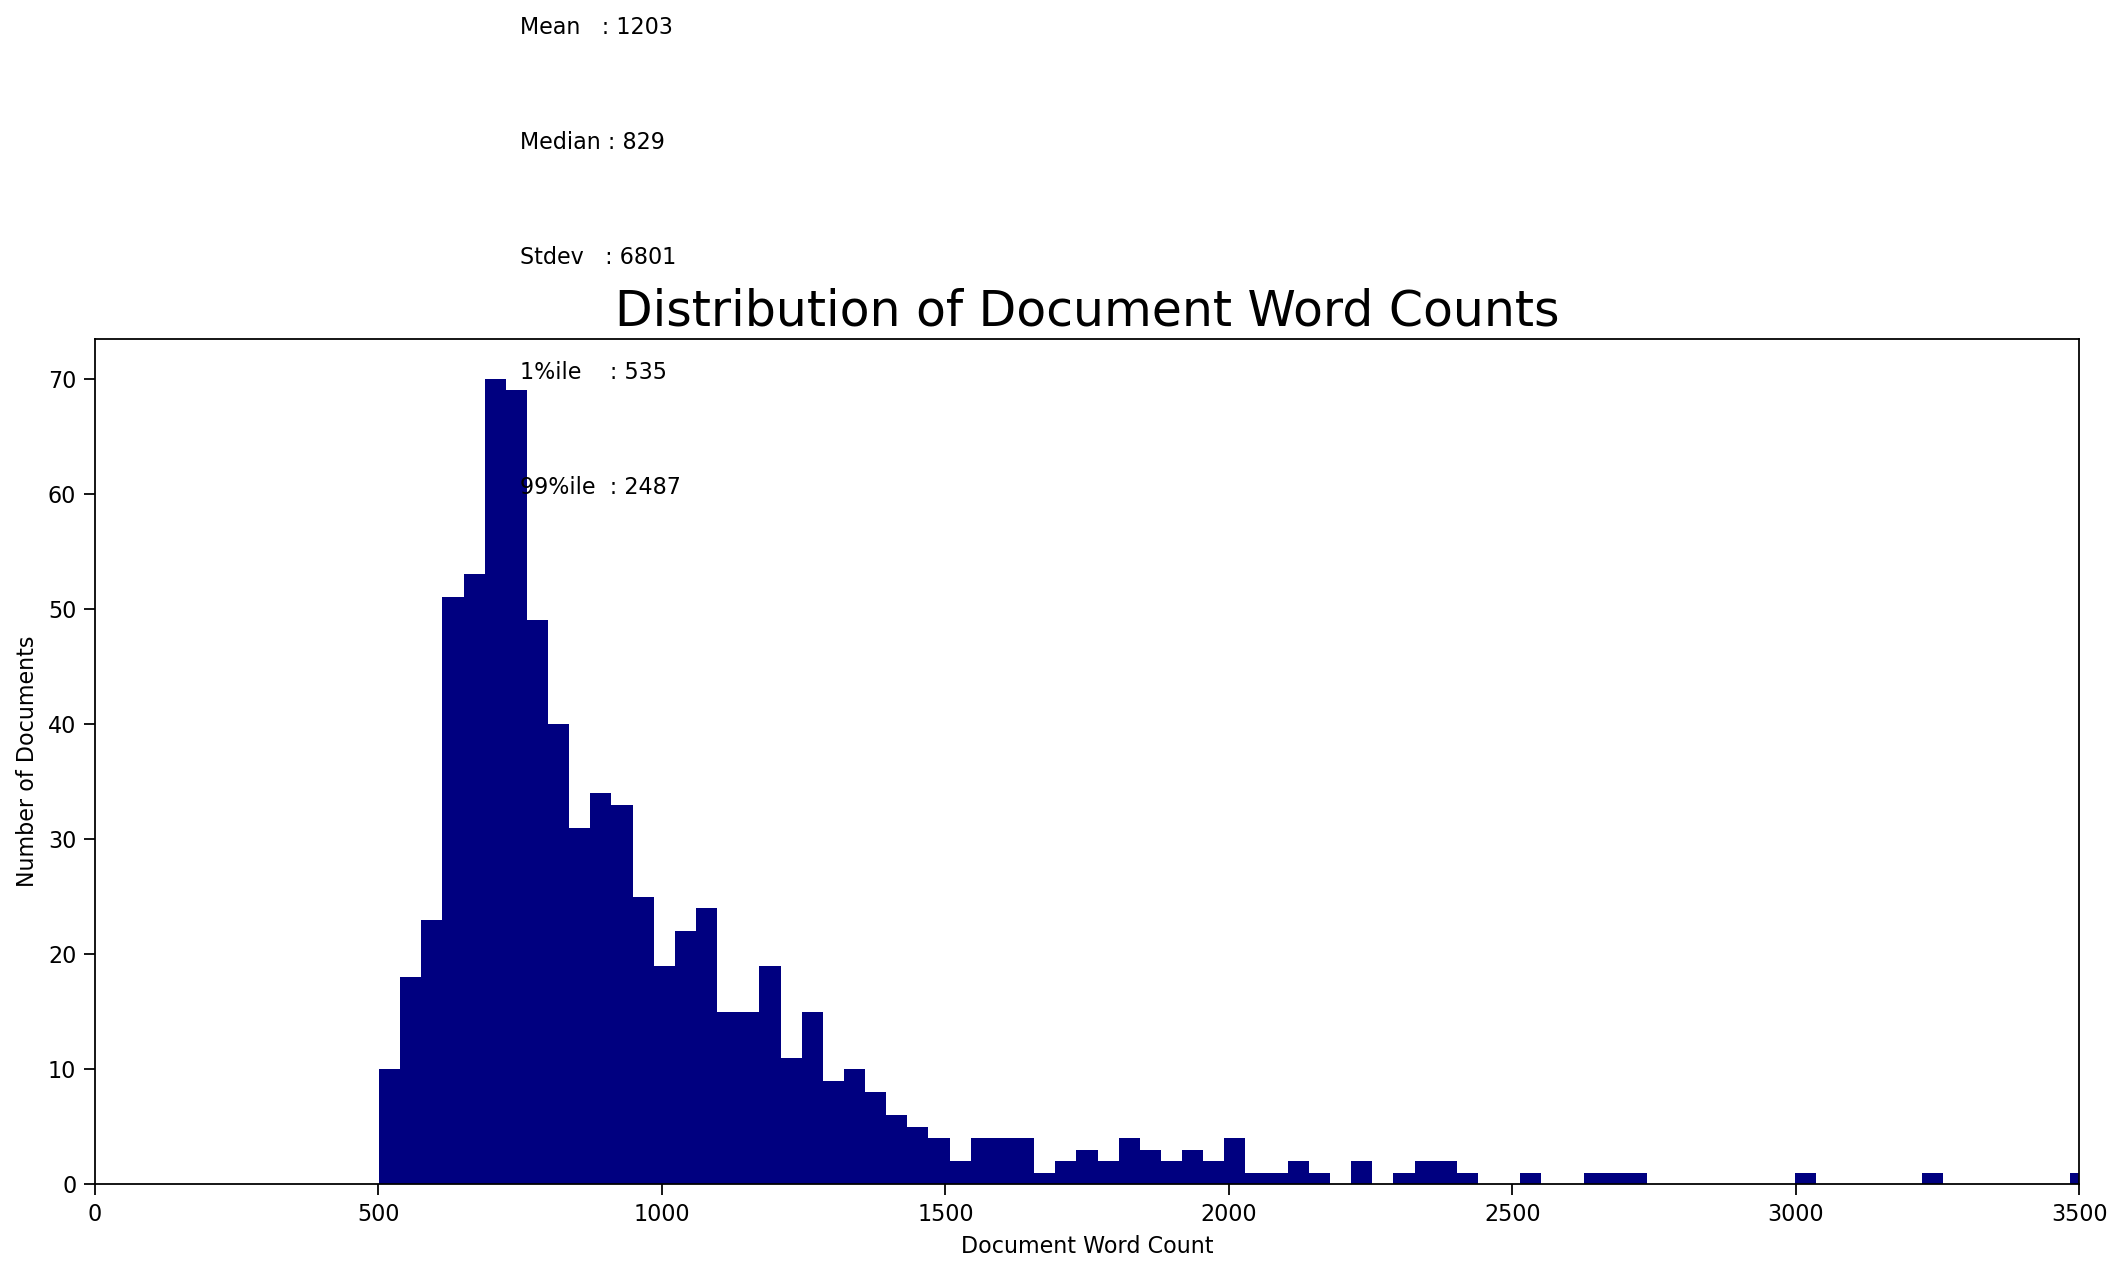

In [323]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 5000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 3500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=5)
plt.xticks(np.linspace(0,3500,8))
# plt.legend(loc = "upper left")
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

ImportError: cannot import name 'find_stack_level' from 'pandas.util._exceptions' (/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_exceptions.py)

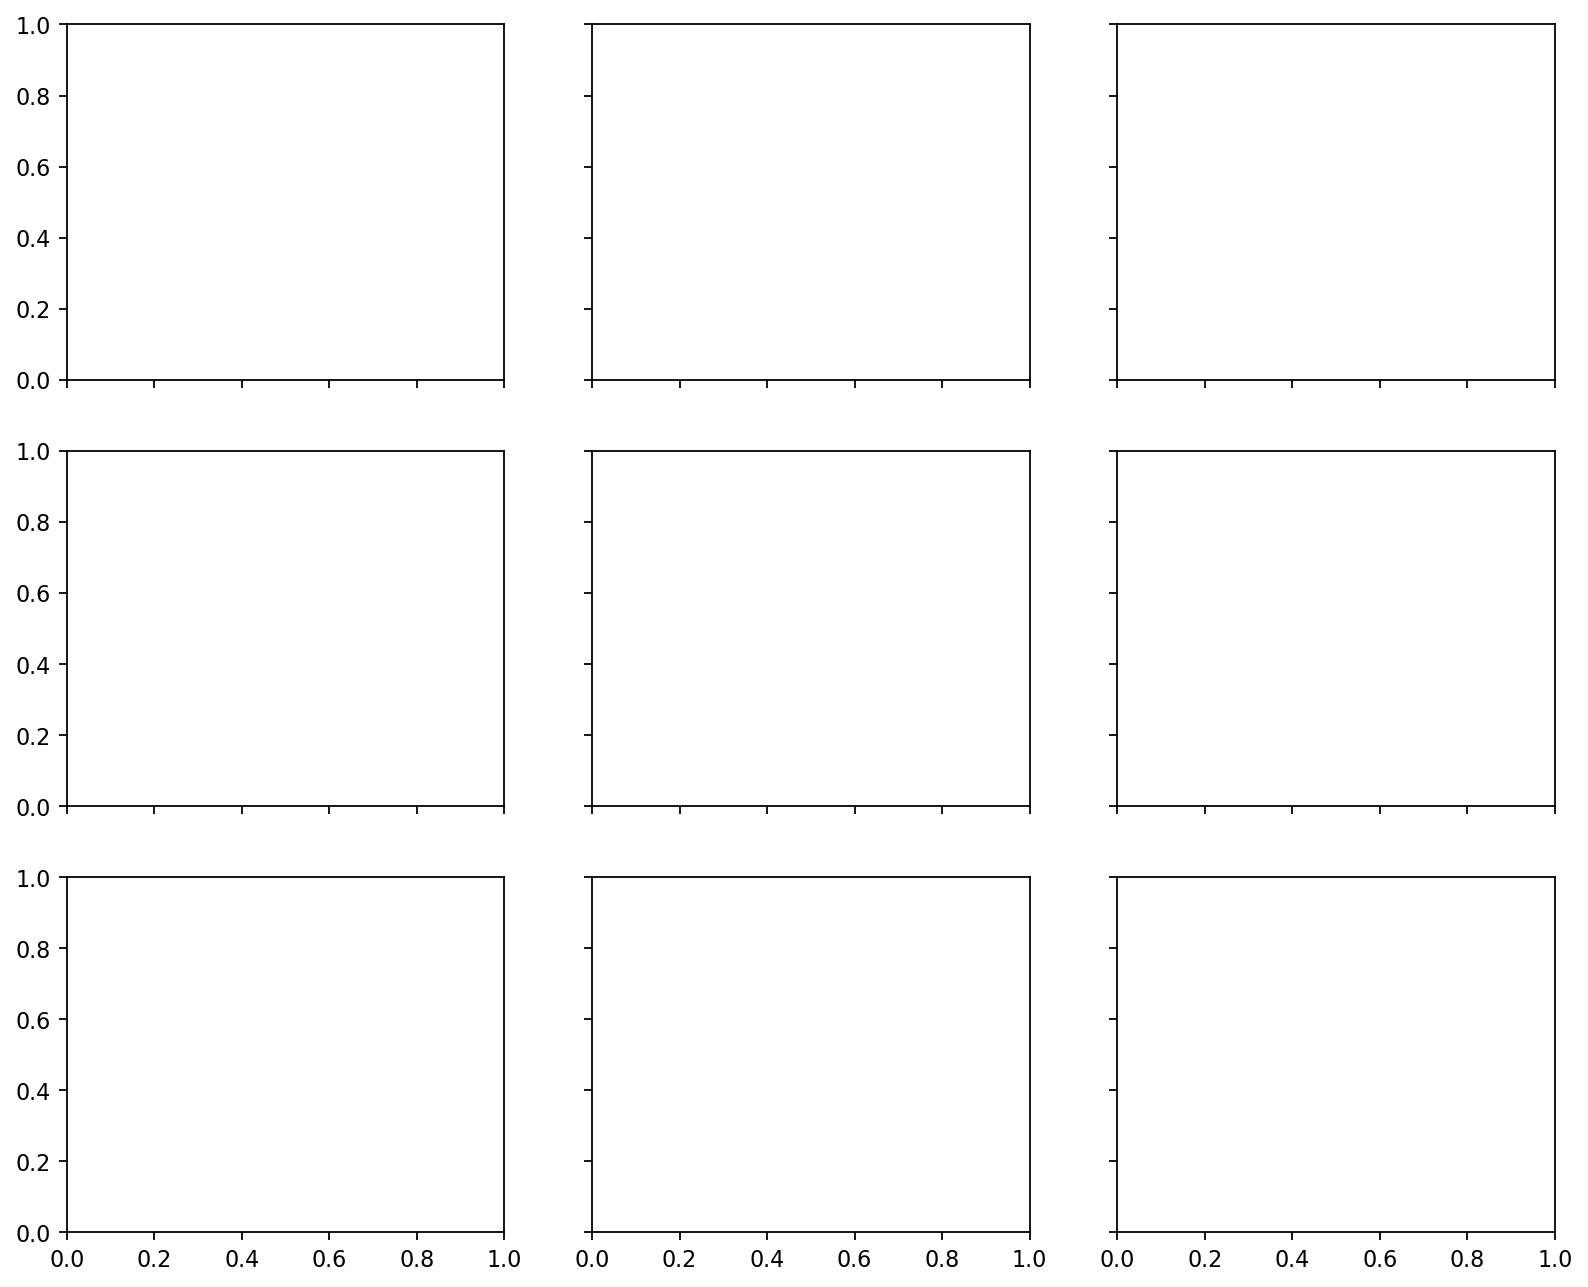

In [326]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(12,10), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 5000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(500, 2500), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(500, 2500,4))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [328]:
# установили wordcloud
!pip install wordcloud

     |████████████████████████████████| 172 kB 859 kB/s eta 0:00:01


In [134]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [332]:
topics = LDA_7_top.show_topics(formatted=False)

In [333]:
topics

[(0,
  [('проект', 0.011506208),
   ('млрд_рубль', 0.00805061),
   ('компания', 0.007891786),
   ('дальний_восток', 0.0075465143),
   ('краснодарский_край', 0.007215493),
   ('развитие', 0.0062185763),
   ('сегодняшний_день', 0.005021053),
   ('регион', 0.004827943),
   ('интернет', 0.0046921964),
   ('оператор', 0.0044716294)]),
 (1,
  [('уголовный_дело', 0.018060401),
   ('пресс_служба', 0.011101999),
   ('правоохранительный_орган', 0.008915817),
   ('сотрудник_полиция', 0.0081073),
   ('следственный_комитет', 0.00794626),
   ('уголовный', 0.006578984),
   ('возбуждать_уголовный', 0.006547945),
   ('лишение_свобода', 0.0058121914),
   ('становиться_известно', 0.0057343184),
   ('Pussy_Riot', 0.005636504)]),
 (2,
  [('владимир_путин', 0.013865086),
   ('партия', 0.007318174),
   ('путин', 0.0072255502),
   ('единый_россия', 0.00649838),
   ('принимать_участие', 0.0064978823),
   ('премьер_министр', 0.006404384),
   ('выборы', 0.006302747),
   ('дмитрий_медведев', 0.006122935),
   ('де

## Облако ключевых слов для каждой темы из LDA модели 

IndexError: list index out of range

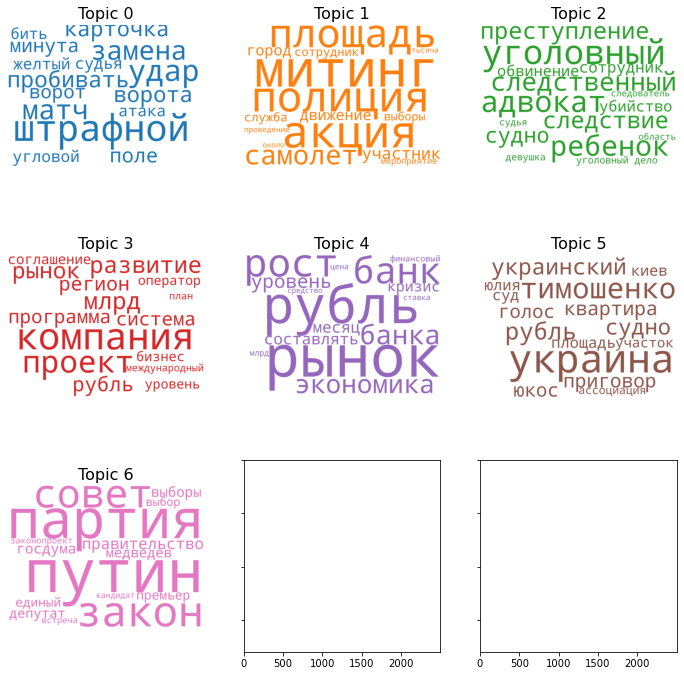

In [162]:
# составной график из облаков слов для каждой темы
# отдельная тема - отдельный цвет ключевых слов
# нужно правильно выбирать количество подграфиков в зависимости от количества тем
# можно играть max_words и num_words 

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDA_7_top.show_topics(num_words=30, formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

https://stackoverflow.com/questions/71720946/topic-modelling-wordcloud-for-every-topic-in-lda-model

In [159]:
# функция для отрисовки облака слов на вход берет LDA модель и тему
# применяют функцию в цикле, который идет по темам LDA модели от 0 до ...

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, topn=30)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

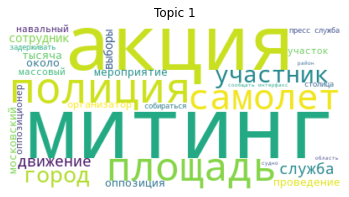

In [160]:
# проверим как отрабатывает
create_wordcloud(LDA_7_top, 1)

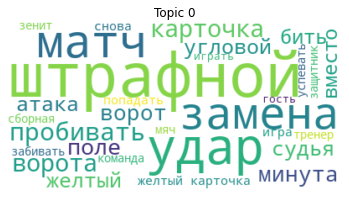

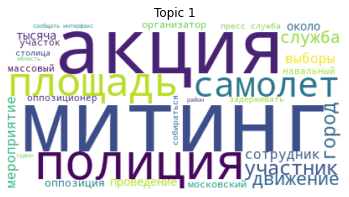

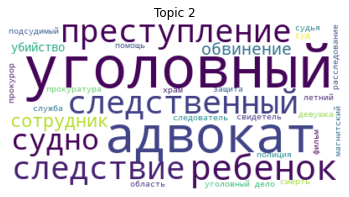

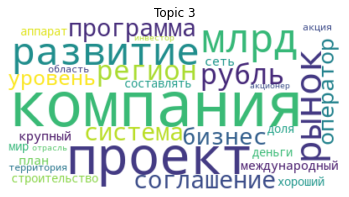

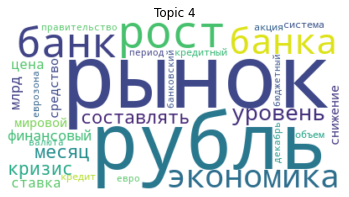

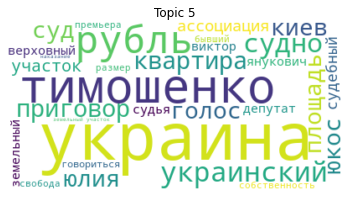

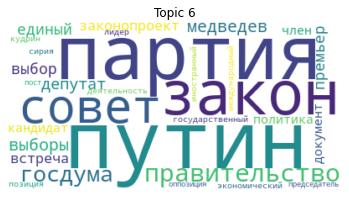

In [161]:
# применим функцию create_wordcloud в цикле для тем LDA модели 
for i in range(0,7):
    create_wordcloud(LDA_7_top, topic=i)

## Кластеры тематики с TSNE

In [163]:
!pip install bokeh

In [164]:
# импорт библиотек
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [357]:
# из doc_lda создадим список списков, в котором в кажом вложенном списке/тексте элементами будут кортеджи (tuple)
# каждый кортедж (номер темы в тексте, вес темы в тексте)
topic_score = []
for i, row_list in enumerate(LDA_7_top[corpus]):
        topic_score.append(row_list[0] if LDA_7_top.per_word_topics else row_list)            
       

In [ ]:
###

In [358]:
# на вход берет строку, список кортежей и количество тем lda модели
# result nt xs - это пустые списки
# на выходе список кортежей в правильном порядке с нулями для тем, которых нет

def topics_order(tuples_row, numb_of_topics, result=None, nt=None, xs=None):
    
    result = [] if result is None else result
    nt = [] if nt is None else nt
    xs = [] if xs is None else xs
 
    for x, y in tuples_row:
        xs.append(x)
        result.append( (x,y) )
    for nx in list(range(numb_of_topics)):
        if nx not in xs:
            nt.append(nx)
    for n in nt:
        result.append( (n, 0) )
    return sorted(result, key=lambda x: (x[0]))

In [359]:
# применим функцию выше
topic_score_ord = [topics_order(row,7) for row in topic_score]

In [360]:
# посмотрим как отработала
topic_score_ord[299]

[(0, 0.08727928),
 (1, 0),
 (2, 0.38069618),
 (3, 0.5315542),
 (4, 0),
 (5, 0),
 (6, 0)]

In [361]:
# получим только веса тем без их номеров (в стандартном порядке) для каждого предложения
# кортежи преобразуются в списки

topic_score_res = [[score[1] for score in t] for t in topic_score_ord]

In [362]:
# посмотрим на результаты
topic_score_res

[[0, 0.023017148, 0, 0.733071, 0.14596811, 0.09754798, 0],
 [0, 0.4479979, 0, 0.19222093, 0.35932288, 0, 0],
 [0, 0.15561979, 0.482581, 0.07262848, 0, 0, 0.28892326],
 [0, 0.016962849, 0, 0.8723504, 0.11036333, 0, 0],
 [0, 0.81916445, 0, 0, 0, 0, 0.18036608],
 [0.10344144, 0, 0, 0.89597154, 0, 0, 0],
 [0, 0, 0, 0.8917016, 0.024890108, 0, 0.08328105],
 [0, 0, 0, 0, 0, 0, 0.9991998],
 [0.015544783, 0.62215585, 0.1750216, 0.093156956, 0.09384446, 0, 0],
 [0, 0, 0.2665421, 0.7328588, 0, 0, 0],
 [0, 0.026707333, 0, 0.77333516, 0.16014482, 0, 0.03965125],
 [0.013846785, 0, 0, 0, 0, 0, 0.985625],
 [0, 0, 0, 0, 0, 0, 0.99937445],
 [0, 0, 0, 0.064331174, 0, 0, 0.93525845],
 [0, 0.16937783, 0.24853283, 0.5815787, 0, 0, 0],
 [0, 0, 0, 0.9993506, 0, 0, 0],
 [0.9996174, 0, 0, 0, 0, 0, 0],
 [0.99958426, 0, 0, 0, 0, 0, 0],
 [0, 0.29830727, 0, 0, 0.030514643, 0, 0.6709681],
 [0, 0.9993224, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0.9993931, 0, 0],
 [0, 0.029946784, 0, 0, 0, 0, 0.9695013],
 [0, 0.38474983, 0.0118

In [363]:
# Сделаем из списка списков датафрейм и заполним пропуски (темы, которых в документе нет) 0 
# и затем df в массив .values (можно также через df.as_matrix())
arr = pd.DataFrame(topic_score_res).values

In [364]:
# посмотрим
arr

array([[0.        , 0.02301715, 0.        , ..., 0.14596811, 0.09754798,
        0.        ],
       [0.        , 0.4479979 , 0.        , ..., 0.35932288, 0.        ,
        0.        ],
       [0.        , 0.15561979, 0.48258099, ..., 0.        , 0.        ,
        0.28892326],
       ...,
       [0.        , 0.        , 0.        , ..., 0.7504521 , 0.        ,
        0.        ],
       [0.99960876, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.89263606, 0.        ,
        0.        ]])

In [365]:
# Keep the well separated points (optional)
# np.amax возвращает максимум массива или максимум вдоль оси
arr = arr[np.amax(arr, axis=1) > 0.35]

In [366]:
arr

array([[0.        , 0.02301715, 0.        , ..., 0.14596811, 0.09754798,
        0.        ],
       [0.        , 0.4479979 , 0.        , ..., 0.35932288, 0.        ,
        0.        ],
       [0.        , 0.15561979, 0.48258099, ..., 0.        , 0.        ,
        0.28892326],
       ...,
       [0.        , 0.        , 0.        , ..., 0.7504521 , 0.        ,
        0.        ],
       [0.99960876, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.89263606, 0.        ,
        0.        ]])

In [367]:
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [368]:
topic_num

array([3, 1, 2, 3, 1, 3, 3, 6, 1, 3, 3, 6, 6, 6, 3, 3, 0, 0, 6, 1, 4, 6,
       3, 3, 3, 3, 3, 0, 2, 2, 6, 2, 6, 0, 6, 0, 2, 4, 1, 3, 4, 4, 2, 1,
       1, 6, 2, 1, 6, 3, 3, 3, 4, 2, 3, 1, 3, 6, 6, 1, 1, 0, 4, 6, 3, 0,
       0, 2, 3, 0, 6, 0, 6, 6, 6, 3, 2, 0, 6, 3, 5, 2, 0, 3, 3, 3, 3, 5,
       3, 6, 6, 1, 3, 0, 2, 6, 3, 6, 4, 6, 2, 1, 5, 2, 1, 1, 2, 0, 0, 6,
       4, 0, 0, 0, 0, 2, 5, 1, 0, 6, 3, 3, 3, 6, 6, 6, 6, 4, 3, 0, 3, 6,
       0, 6, 6, 2, 0, 3, 6, 2, 2, 6, 3, 3, 2, 4, 1, 1, 0, 6, 6, 3, 2, 0,
       1, 3, 2, 2, 2, 6, 2, 4, 2, 0, 6, 1, 6, 0, 3, 6, 1, 2, 3, 2, 1, 3,
       0, 0, 6, 6, 0, 6, 0, 2, 3, 0, 2, 0, 3, 0, 1, 3, 3, 3, 2, 2, 2, 5,
       6, 0, 0, 5, 5, 1, 0, 6, 3, 1, 6, 2, 0, 6, 3, 0, 3, 2, 6, 6, 3, 2,
       3, 6, 3, 3, 3, 6, 3, 1, 1, 3, 6, 3, 2, 2, 3, 2, 0, 6, 1, 3, 2, 6,
       5, 2, 6, 2, 6, 6, 2, 3, 0, 2, 6, 2, 4, 6, 3, 3, 6, 2, 0, 6, 2, 6,
       2, 6, 4, 6, 4, 6, 1, 6, 6, 6, 3, 4, 0, 0, 3, 1, 2, 2, 2, 6, 0, 2,
       1, 4, 3, 3, 2, 3, 6, 1, 2, 3, 6, 3, 3, 0, 3,

In [369]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 744 samples in 0.019s...
[t-SNE] Computed neighbors for 744 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 744 / 744
[t-SNE] Mean sigma: 0.000065
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.022865
[t-SNE] KL divergence after 1000 iterations: 0.355233


In [370]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 7
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

### Функция которая переписывает строку (список кортежей) с темами и их долями в тексте в порядке от 0 до ...

In [352]:
# на вход берет строку, список кортежей и количество тем lda модели
# result nt xs - это пустые списки
# на выходе список кортежей в правильном порядке с нулями для тем, которых нет

def topics_order(tuples_row, numb_of_topics, result=None, nt=None, xs=None):
    
    result = [] if result is None else result
    nt = [] if nt is None else nt
    xs = [] if xs is None else xs
 
    for x, y in tuples_row:
        xs.append(x)
        result.append( (x,y) )
    for nx in list(range(numb_of_topics)):
        if nx not in xs:
            nt.append(nx)
    for n in nt:
        result.append( (n, 0) )
    return sorted(result, key=lambda x: (x[0]))

In [ ]:


# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 7
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)